## Deep Q-Network: Double DQN

说模型基础上进一步缓解自举

计算target的时候，使用原来模型计算动作，延迟模型计算target,而不是直接取max

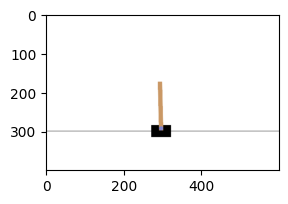

In [1]:
import gym

# 定义环境
class MyWrapper(gym.Wrapper):
  
  def __init__(self):
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    super().__init__(env)
    self.env = env
    self.step_n = 0
    
  def reset(self):
    state, _ = self.env.reset()
    self.step_n = 0
    return state
  
  def step(self, action):
    state, reward, terminated, truncated, info = self.env.step(action)
    over = terminated or truncated

    #限制最大步数
    self.step_n += 1
    if self.step_n >= 200:
        over = True
    
    #没坚持到最后,扣分
    if over and self.step_n < 200:
        reward = -1000

    return state, reward, over
  
  # 打印游戏图像
  def show(self):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(3, 3))
    plt.imshow(self.env.render())
    plt.show()
    
env = MyWrapper()

env.reset()

env.show()

In [2]:
import torch

#定义模型,评估状态下每个动作的价值
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#延迟更新的模型,用于计算target
model_delay = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

#复制参数
model_delay.load_state_dict(model.state_dict())

model, model_delay


(Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=4, out_features=64, bias=True)
   (1): ReLU()
   (2): Linear(in_features=64, out_features=64, bias=True)
   (3): ReLU()
   (4): Linear(in_features=64, out_features=2, bias=True)
 ))

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
  data = []
  reward_sum = 0

  state = env.reset()
  over = False
  while not over:
    action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
    if random.random() < 0.1:
      action = env.action_space.sample()

    next_state, reward, over = env.step(action)

    data.append((state, action, reward, next_state, over))
    reward_sum += reward

    state = next_state

    if show:
      display.clear_output(wait=True)
      env.show()

  return data, reward_sum


play()[-1]

-992.0

In [4]:
#数据池
class Pool:

  def __init__(self):
    self.pool = []
    self.prob = [] # code changed

  def __len__(self):
    return len(self.pool)

  def __getitem__(self, i):
    return self.pool[i]

  #更新动作池
  def update(self):
    #每次更新不少于N条新数据
    old_len = len(self.pool)
    while len(pool) - old_len < 200:
      "code change begin"
      self.pool.extend(play()[0])
      "code change end"

    #只保留最新的N条数据
    self.pool = self.pool[-2_0000:]
    # self.prob = self.prob[-2_0000:] # code changed

  #获取一批数据样本
  def sample(self):
    # idx = torch.FloatTensor(self.prob).clamp(0.1, 1.0).multinomial(
    #   num_samples=64, replacement=False
    # ) # code chaged
    data = random.sample(self.pool, 64) # code changed back

    state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)
    action = torch.LongTensor([i[1] for i in data]).reshape(-1, 1)
    reward = torch.FloatTensor([i[2] for i in data]).reshape(-1, 1)
    next_state = torch.FloatTensor([i[3] for i in data]).reshape(-1, 4)
    over = torch.LongTensor([i[4] for i in data]).reshape(-1, 1)

    return state, action, reward, next_state, over # code changed


pool = Pool()
pool.update()
pool.sample()

len(pool), pool[0]

C:\Users\fanyu\AppData\Local\Temp\ipykernel_13752\2160598233.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.FloatTensor([i[0] for i in data]).reshape(-1, 4)


(208,
 (array([-0.02506987, -0.02175042,  0.00115388,  0.04075105], dtype=float32),
  1,
  1.0,
  array([-0.02550488,  0.17335497,  0.0019689 , -0.2515676 ], dtype=float32),
  False))

In [6]:
#训练
def train():
  model.train()
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
  loss_fn = torch.nn.MSELoss()

  #共更新N轮数据
  for epoch in range(1000):
    pool.update()

    #每次更新数据后,训练N次
    for i in range(200):

      #采样N条数据
      state, action, reward, next_state, over = pool.sample() # code changed back

      #计算value
      value = model(state).gather(dim=1, index=action)

      #计算target
      with torch.no_grad():
        "code changed here"
        # 原模型计算动作，延迟模型计算target
        next_action = model(next_state).argmax(dim=1, keepdim=True)
        target = model_delay(next_state).gather(dim=1, index=next_action)
        
      target = target * 0.99 * (1 - over) + reward
      "code changed end"
      
      # # 根据概率缩放loss
      # r = torch.FloatTensor([pool.prob[i] for i in idx])
      # r = (1 - r).clamp(0.1, 1.0).reshape(-1, 1)
      
      loss = loss_fn(value, target)
      # (loss * r).mean(0).backward()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      # 根据loss调整权重
      # for i, j in zip(idx.tolist(), loss.abs().sigmoid().flatten().tolist()):
      #   pool.prob[i] = j
      "code change end"

    #复制参数
    if (epoch + 1) % 5 == 0:
      model_delay.load_state_dict(model.state_dict())

    if epoch % 100 == 0:
      test_result = sum([play()[-1] for _ in range(20)]) / 20
      print(epoch, len(pool), test_result) # code changed


train()

0 20000 200.0
100 20000 200.0
200 20000 200.0
300 20000 200.0
400 20000 200.0
500 20000 200.0
600 20000 200.0
700 20000 200.0
800 20000 200.0
900 20000 143.85


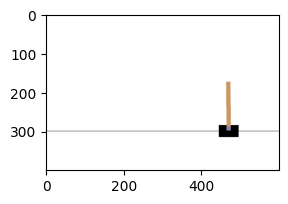

200.0

In [7]:
play(True)[-1]